# **1. Load Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


# 0. Global Path Config
# ⬇️
RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    BASE_DIR = '/content/drive/MyDrive/CA6000_Assignment_WANGHaocheng'

else:
    BASE_DIR = '.'

# 1. Load Data
csv_path = os.path.join(BASE_DIR, 'data', 'Metro_Interstate_Traffic_Volume.csv')
df = pd.read_csv(csv_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2.Raw Data Diagonsis**

## **2.1. Manual Inspection**

In [ ]:
print(df)

       traffic_volume holiday    temp  rain_1h  snow_1h  clouds_all  \
0                5545     NaN  288.28      0.0      0.0          40   
1                4516     NaN  289.36      0.0      0.0          75   
2                4767     NaN  289.58      0.0      0.0          90   
3                5026     NaN  290.13      0.0      0.0          90   
4                4918     NaN  291.14      0.0      0.0          75   
...               ...     ...     ...      ...      ...         ...   
48199            3543     NaN  283.45      0.0      0.0          75   
48200            2781     NaN  282.76      0.0      0.0          90   
48201            2159     NaN  282.73      0.0      0.0          90   
48202            1450     NaN  282.09      0.0      0.0          90   
48203             954     NaN  282.12      0.0      0.0          90   

       weather_main     weather_description         date_time  
0            Clouds        scattered clouds  02-10-2012 09:00  
1            Clouds

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       48204 non-null  int64  
 1   holiday              61 non-null     object 
 2   temp                 48204 non-null  float64
 3   rain_1h              48204 non-null  float64
 4   snow_1h              48204 non-null  float64
 5   clouds_all           48204 non-null  int64  
 6   weather_main         48204 non-null  object 
 7   weather_description  48204 non-null  object 
 8   date_time            48204 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [ ]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,3259.818355,281.205870,0.334264,0.000222,49.362231
std,1986.860670,13.338232,44.789133,0.008168,39.015750
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1193.000000,272.160000,0.000000,0.000000,1.000000
50%,3380.000000,282.450000,0.000000,0.000000,64.000000
75%,4933.000000,291.806000,0.000000,0.000000,90.000000
max,7280.000000,310.070000,9831.300000,0.510000,100.000000


## **2.2. Examine Potential Issues**

Prompt:

Based on the outputs of df.info(), df.describe(), and manual inspection of the dataset, several potential data quality concerns are suspected, but have not yet been formally verified:

1. The variables temp, rain_1h, and snow_1h may contain implausible values or outliers that could affect statistical analysis and model performance.

2. The features holiday, rain_1h, snow_1h, and clouds_all may exhibit sparsity, with a large proportion of binary or zero-valued entries.

3. The date_time, and holiday may contain missing values or duplicated timestamps, which could compromise the integrity of the time-series data.

4. The weather_main and weather_description may have high cardinality, and the semantic consistency of its categorical values (rain_1h, snow_1h, and clouds_all) is uncertain.

Please write Python code to systematically examine these potential issues and use print() statements to summarize the diagnostic findings in the console, including whether each issue is confirmed and relevant supporting details.

In [ ]:
def diagnose_data_issues_reordered(df):
    """
    Systematic Data Diagnosis (Reordered as per User Request):
    1. Implausible Values (Temp/Rain/Snow)
    2. Sparsity (Holiday/Rain/Snow/Clouds)
    3. Time-Series & Holiday Integrity (Timestamp gaps + Holiday missing years/duplicates)
    4. Categorical Consistency (Cardinality & Semantic Logic)
    """
    print("--- Initiating Systematic Data Diagnosis (Reordered) ---\n")

    results = {}

    # Preprocessing: Ensure datetime format
    if 'date_time' in df.columns:
        if not np.issubdtype(df['date_time'].dtype, np.datetime64):
             df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True, errors='coerce')
        df['year'] = df['date_time'].dt.year

    # ==============================================================================
    # 1. HYPOTHESIS: Implausible Values / Outliers (temp, rain_1h, snow_1h)
    # ==============================================================================
    # Check Temp: < 200K (Physically Impossible)
    low_temp_count = (df['temp'] < 200).sum() if 'temp' in df.columns else 0

    # Check Rain: > 100mm (Extreme)
    max_rain = df['rain_1h'].max() if 'rain_1h' in df.columns else 0
    extreme_rain_count = (df['rain_1h'] > 100).sum() if 'rain_1h' in df.columns else 0

    # Check Snow: Max value too low (Sensor suspicion)
    max_snow = df['snow_1h'].max() if 'snow_1h' in df.columns else 0
    is_snow_plausible = max_snow > 1.0

    results['outliers'] = {
        'low_temp_count': low_temp_count,
        'max_rain': max_rain,
        'extreme_rain_count': extreme_rain_count,
        'max_snow': max_snow,
        'is_snow_plausible': is_snow_plausible
    }

    # ==============================================================================
    # 2. HYPOTHESIS: Sparsity (holiday, rain_1h, snow_1h, clouds_all)
    # ==============================================================================
    sparsity_stats = {}

    # Check numeric sparsity (0 or 1 dominance)
    for col in ['rain_1h', 'snow_1h', 'clouds_all']:
        if col in df.columns:
            sparsity_stats[col] = df[col].isin([0, 1]).mean() * 100

    # Check holiday sparsity ('None' dominance)
    if 'holiday' in df.columns:
        holiday_sparsity = df['holiday'].apply(lambda x: str(x).lower() == 'none' or pd.isna(x)).mean() * 100
        sparsity_stats['holiday'] = holiday_sparsity

    results['sparsity'] = sparsity_stats

    # ==============================================================================
    # 3. HYPOTHESIS: Time-Series & Holiday Integrity (date_time, holiday)
    # ==============================================================================
    # Part A: Date_Time Integrity
    duplicate_time_count = df.duplicated(subset=['date_time']).sum()

    min_time = df['date_time'].min()
    max_time = df['date_time'].max()
    missing_hours = 0
    if pd.notna(min_time) and pd.notna(max_time):
        expected_range = pd.date_range(start=min_time, end=max_time, freq='h')
        missing_hours = len(expected_range) - df['date_time'].nunique()

    # Part B: Holiday Integrity (Audit for Missing Years/Duplicates)
    holiday_issues = {'missing': [], 'duplicates': []}
    if 'holiday' in df.columns:
        holiday_subset = df[df['holiday'] != 'None']
        if not holiday_subset.empty:
            # Pivot: Year vs Holiday Name
            holiday_matrix = pd.crosstab(holiday_subset['year'], holiday_subset['holiday'])

            for year in holiday_matrix.index:
                for holiday_name in holiday_matrix.columns:
                    count = holiday_matrix.loc[year, holiday_name]
                    if count == 0:
                        holiday_issues['missing'].append(f"{year} Missing {holiday_name}")
                    elif count > 1:
                        holiday_issues['duplicates'].append(f"{year} {holiday_name} (x{count})")

    results['integrity'] = {
        'time_duplicates': duplicate_time_count,
        'missing_hours': missing_hours,
        'holiday_issues': holiday_issues
    }

    # ==============================================================================
    # 4. HYPOTHESIS: Categorical Consistency (weather_main/description)
    # ==============================================================================
    # Part A: Cardinality
    cardinality = {
        'weather_main': df['weather_main'].nunique() if 'weather_main' in df.columns else 0,
        'weather_description': df['weather_description'].nunique() if 'weather_description' in df.columns else 0
    }

    # Part B: Semantic Consistency (Text vs Number Mismatch)
    conflicts = {}
    if 'weather_main' in df.columns:
        if 'snow_1h' in df.columns:
            conflicts['main_snow_mismatch'] = df[
                (df['weather_main'].str.contains('snow', case=False, na=False)) & (df['snow_1h'] == 0)
            ].shape[0]
        if 'rain_1h' in df.columns:
            conflicts['main_rain_mismatch'] = df[
                (df['weather_main'].str.contains('rain', case=False, na=False)) & (df['rain_1h'] == 0)
            ].shape[0]

    results['categorical'] = {
        'cardinality': cardinality,
        'conflicts': conflicts
    }

    # ==============================================================================
    # 5. PRINT DIAGNOSTIC SUMMARY (Ordered)
    # ==============================================================================
    print("="*70)
    print("DIAGNOSTIC SUMMARY REPORT")
    print("="*70)

    # 1. Implausible Values
    print("\n1. IMPLAUSIBLE VALUES & OUTLIERS")
    print(f"   - Temp < 200K (Impossible): {results['outliers']['low_temp_count']} rows.")
    print(f"   - Rain > 100mm (Extreme):   {results['outliers']['extreme_rain_count']} rows (Max: {results['outliers']['max_rain']}mm).")
    snow_status = "Suspicious (Too Low)" if not results['outliers']['is_snow_plausible'] else "Normal"
    print(f"   - Snow Max Value Check:     Max {results['outliers']['max_snow']}mm -> {snow_status}.")

    # 2. Sparsity
    print("\n2. SPARSITY CHECK")
    for col, pct in results['sparsity'].items():
        print(f"   - {col}: {pct:.2f}% are Null/Zero/None.")
    print("   >>> Conclusion: High sparsity in physical features limits their variance contribution.")

    # 3. Time-Series & Holiday Integrity
    print("\n3. TIME-SERIES & HOLIDAY INTEGRITY")
    print(f"   [Time Check]:")
    print(f"     - Missing Time Steps:    {results['integrity']['missing_hours']} hours.")
    print(f"     - Duplicated Timestamps: {results['integrity']['time_duplicates']} rows.")

    print(f"   [Holiday Check]:")
    h_miss = results['integrity']['holiday_issues']['missing']
    h_dup = results['integrity']['holiday_issues']['duplicates']

    if len(h_miss) == 0 and len(h_dup) == 0:
        print("     ✅ Holiday data is balanced across years.")
    else:
        if h_miss: print(f"     ❌ Missing Holidays: {len(h_miss)} instances (e.g., {h_miss[:2]}).")
        if h_dup:  print(f"     ⚠️ Duplicate Holidays: {len(h_dup)} instances (e.g., {h_dup[:2]}).")
        print("     >>> Conclusion: Holiday data requires regeneration using standard libraries.")

    # 4. Categorical Consistency
    print("\n4. CATEGORICAL CONSISTENCY")
    print(f"   - Cardinality: weather_main ({results['categorical']['cardinality']['weather_main']}) vs description ({results['categorical']['cardinality']['weather_description']}).")
    print(f"   - Semantic Mismatches (Text vs Number):")
    print(f"     * 'Snow' text but 0 volume: {results['categorical']['conflicts'].get('main_snow_mismatch', 0)} rows.")
    print(f"     * 'Rain' text but 0 volume: {results['categorical']['conflicts'].get('main_rain_mismatch', 0)} rows.")

    if results['categorical']['conflicts'].get('main_snow_mismatch', 0) > 1000:
        print("   >>> Conclusion: Text labels contradict numerical data. Rely on numerical columns (with cleaning).")
    else:
        print("   >>> Conclusion: Text and numbers are generally consistent.")

    print("="*70)

# 执行诊断
diagnose_data_issues_reordered(df)

--- Initiating Systematic Data Diagnosis (Reordered) ---

DIAGNOSTIC SUMMARY REPORT

1. IMPLAUSIBLE VALUES & OUTLIERS
   - Temp < 200K (Impossible): 10 rows.
   - Rain > 100mm (Extreme):   1 rows (Max: 9831.3mm).
   - Snow Max Value Check:     Max 0.51mm -> Suspicious (Too Low).

2. SPARSITY CHECK
   - rain_1h: 92.82% are Null/Zero/None.
   - snow_1h: 99.87% are Null/Zero/None.
   - clouds_all: 30.60% are Null/Zero/None.
   - holiday: 99.87% are Null/Zero/None.
   >>> Conclusion: High sparsity in physical features limits their variance contribution.

3. TIME-SERIES & HOLIDAY INTEGRITY
   [Time Check]:
     - Missing Time Steps:    11976 hours.
     - Duplicated Timestamps: 7629 rows.
   [Holiday Check]:
     ❌ Missing Holidays: 24 instances (e.g., ['2012 Missing Independence Day', '2012 Missing Labor Day']).
     ⚠️ Duplicate Holidays: 7 instances (e.g., ['2015 Thanksgiving Day (x2)', '2016 Christmas Day (x2)']).
     >>> Conclusion: Holiday data requires regeneration using standard li

# **3. EDA**

## **3.1. Generation of Canonical Weekly Traffic Profile**

Prompt:

**1. Objective**
To characterize and visualize the standard weekly traffic pattern of the Interstate 94 (I-94) highway, revealing underlying temporal periodicity and traffic intensity fluctuations over a typical 7-day cycle.

**2. Data Processing Methodology**
* **Temporal Scope:** The analysis aggregates data over a span of approximately **5.5 years (286 weeks)**.
* **Aggregation Strategy:** Traffic volume data was grouped into `(Day of Week, Hour of Day)` buckets.
* **Statistical Metrics:** The **Mean** (central tendency) and **Standard Deviation** (volatility) were calculated for each of the 168 hours in a week.
* **Alignment:** The timeline is aligned to start from **Monday 00:00** to strictly observe the "Work week" to "Weekend" transition.

**3. Visualization Configuration**
* **Plot Type:** Line chart with confidence intervals (±1 Std Dev).
* **Color Palette:** Utilizes the `PuBuGn` colormap for visual consistency with the overall project theme.
    * **Weekdays (Mon-Fri):** Rendered in a **darker shade** to signify primary commuting days.
    * **Weekends (Sat-Sun):** Rendered in a **lighter/medium shade** to distinguish leisure/non-commute patterns.
* **Uncertainty Representation:** A shaded gray area represents the traffic volatility (±1 Standard Deviation) to highlight the variability of traffic flow at specific hours.
* **Grid Layout:** Vertical grid lines are included to clearly demarcate daily boundaries (midnight).

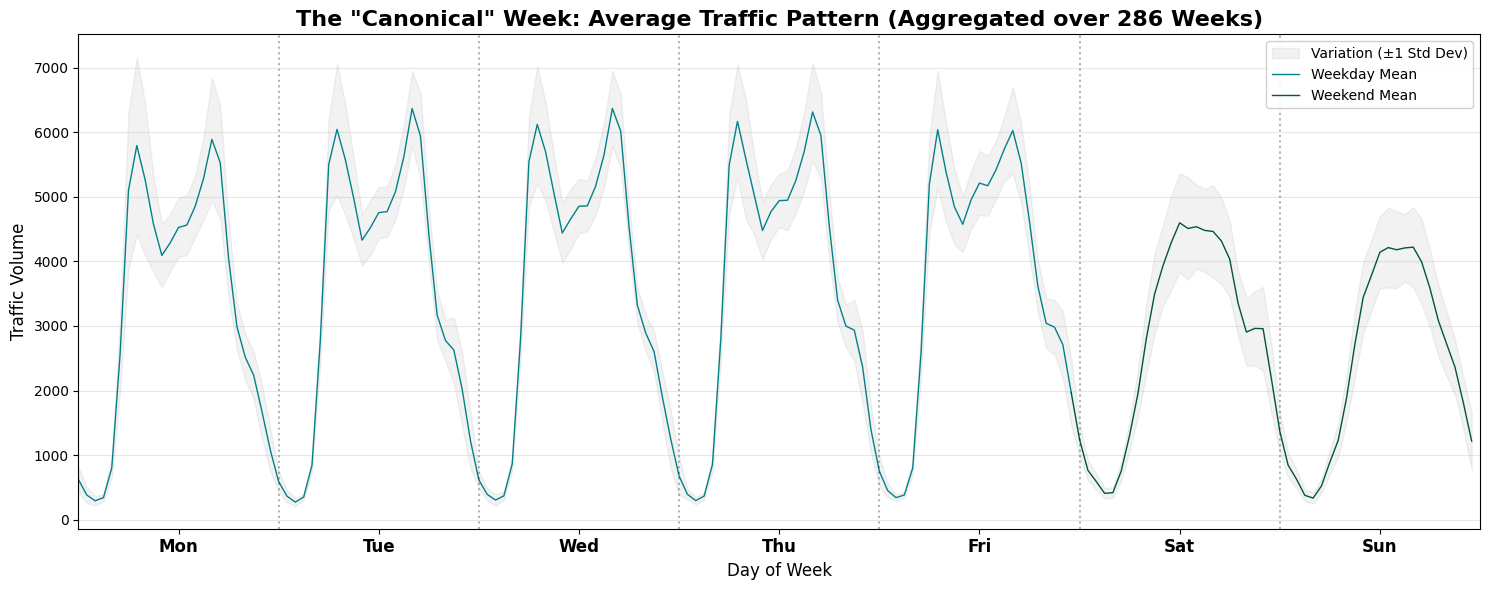

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 0. Isolation: Create a Copy
# ==========================================
# We create a deep copy 'df_viz' specifically for this visualization.
# The original 'df' will remain UNTOUCHED for your downstream analysis.
df_viz = df.copy()

# ==========================================
# 1. Preprocessing (On the Copy Only)
# ==========================================
# Check and fix index only on df_viz
if not isinstance(df_viz.index, pd.DatetimeIndex):
    time_col = 'date_time'  # Adjust column name if needed
    if time_col in df_viz.columns:
        # 'dayfirst=True' handles 13-10-2012 format
        df_viz[time_col] = pd.to_datetime(df_viz[time_col], dayfirst=True, errors='coerce')
        df_viz.dropna(subset=[time_col], inplace=True)
        df_viz.set_index(time_col, inplace=True)
        df_viz.sort_index(inplace=True)

# ==========================================
# 2. Data Preparation
# ==========================================
# Add temporary columns to the copy
df_viz['day_of_week'] = df_viz.index.dayofweek
df_viz['hour'] = df_viz.index.hour

# Aggregation: Group by Day and Hour
weekly_stats = df_viz.groupby(['day_of_week', 'hour'])['traffic_volume'].agg(['mean', 'std'])

# Extract values (Numpy arrays) - at this point we are done with df_viz
mean_week = weekly_stats['mean'].values
std_week = weekly_stats['std'].values

# ==========================================
# 3. Visualization: The "Canonical" Week
# ==========================================
# Define Color Palette (PuBuGn)
cmap = plt.get_cmap('PuBuGn')
c_weekday = cmap(0.75)  # Darker shade for weekdays
c_weekend = cmap(0.95)  # Lighter/Medium shade for weekend
c_std_dev = 'grey'      # Neutral color for variance

fig, ax = plt.subplots(figsize=(15, 6))
hours = np.arange(168)

# --- A. Plot Standard Deviation (Uncertainty Range) ---
ax.fill_between(hours,
                mean_week - std_week,
                mean_week + std_week,
                color=c_std_dev, alpha=0.1, label='Variation (±1 Std Dev)')

# --- B. Plot Mean Traffic Lines ---
# Weekday (Mon 00:00 - Fri 23:59)
ax.plot(hours[:120], mean_week[:120], color=c_weekday, linewidth=1, label='Weekday Mean')
# Weekend (Fri 23:00 - Sun 23:59) - Slight overlap for continuity
ax.plot(hours[119:], mean_week[119:], color=c_weekend, linewidth=1, label='Weekend Mean')

# --- C. Styling & Annotations ---
for day in range(1, 7):
    ax.axvline(x=day * 24, color='black', linestyle=':', alpha=0.3)

# X-Axis Labels
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticks(np.arange(12, 168, 24))
ax.set_xticklabels(days_labels, fontsize=12, fontweight='bold')

# Titles and Legends
num_weeks = len(df_viz) // 168
ax.set_title(f'The "Canonical" Week: Average Traffic Pattern (Aggregated over {num_weeks} Weeks)',
             fontsize=16, fontweight='bold')
ax.set_ylabel('Traffic Volume', fontsize=12)
ax.set_xlabel('Day of Week', fontsize=12)

ax.set_xlim(0, 168)
ax.grid(True, axis='y', alpha=0.3)
ax.legend(loc='upper right', frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

# Optional: Clean up the temporary dataframe to free memory
del df_viz

## **3.2. Correlation Analysis**
Prompt: I would like to perform both linear and nonlinear correlation analysis on a traffic time-series dataset.
Before conducting the analysis, please apply the following structured data preprocessing pipeline:

1. Physical Cleaning (Physics Constraints & Outliers)

    Rain: Drop all rows where rain_1h > 100 mm, as such values are physically implausible and represent extreme outliers (e.g., the isolated 9831 mm record).

    Temperature: Identify invalid temperature values (e.g., 0 K) and repair them using linear interpolation.

2. Holiday Replacement and Encoding

    Use the holidays library to generate a binary feature is_holiday (0/1).

    If a date is identified as a holiday, propagate the holiday label to all 24 hours of that day.

    Replace the original string-based holiday column entirely with this binary indicator to ensure consistency and facilitate downstream analysis.

3. Time Feature Extraction from date_time

    Parse the date_time column as a datetime object.

    Extract and create the following time-based features:  (hour / day_of_week / day / month / year)

    Retain these extracted features for subsequent correlation analysis.

4. Weather One-Hot Encoding

    Target column: weather_main.

    Apply one-hot encoding using pd.get_dummies.

    This should generate binary features such as weather_Clear, weather_Rain, weather_Mist, etc.

Correlation Analysis Requirements

After completing the above preprocessing steps, please:

1. Conduct a linear correlation analysis (e.g., Pearson correlation) between all engineered features and the target variable.

2. Conduct a nonlinear feature relevance analysis (e.g., using a tree-based model such as Random Forest).

3. Clearly summarize and interpret the results, highlighting:

    Dominant features

    Features with weak or negligible influence

    Any notable differences between linear and nonlinear relationships

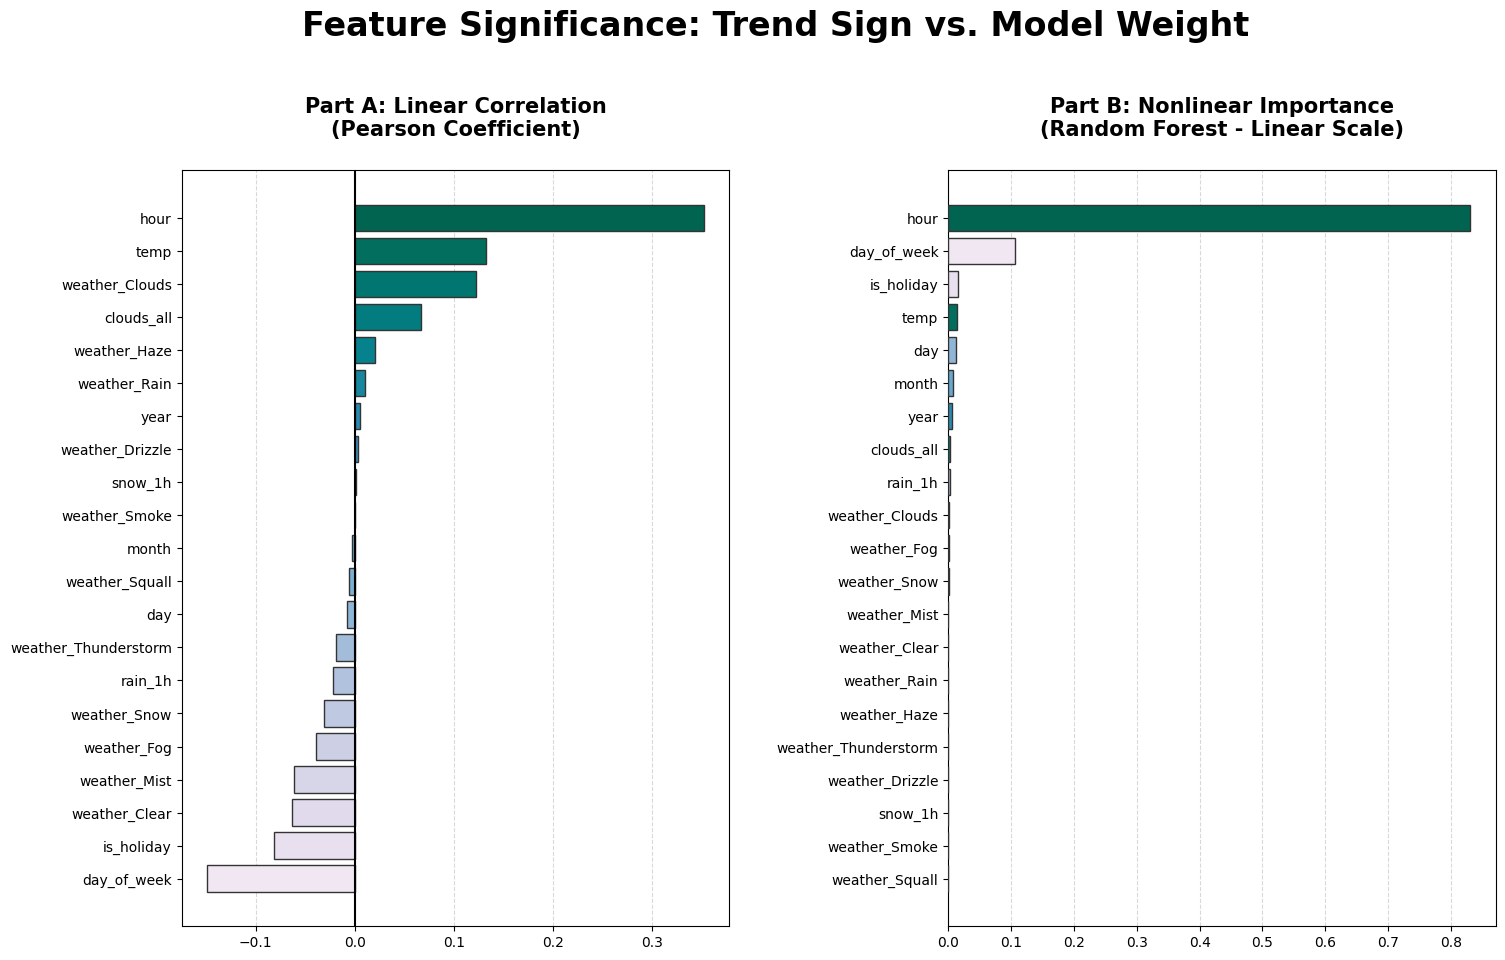

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import holidays

def dual_feature_analysis_report(df_raw):
    """
    Streamlined Analysis: Pearson Correlation vs. RF Feature Importance.
    Focuses on Magnitude and Sign for rapid feature selection.
    """
    df = df_raw.copy()

    # --- 1. Data Cleaning & Feature Engineering ---
    # Remove physically impossible rain values
    df = df[df['rain_1h'] <= 100]
    # Repair invalid temperature (0 K) via interpolation
    df['temp'] = df['temp'].replace(0, np.nan).interpolate()

    # Process Time and Holiday features
    us_holidays = holidays.US()
    df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True)
    df['is_holiday'] = df['date_time'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

    # Extract structural time components
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['month'] = df['date_time'].dt.month

    # Convert Categorical Weather to Numeric Dummies (Forcing int for Correlation)
    df = pd.get_dummies(df, columns=['weather_main'], prefix='weather', dtype=int)

    # --- 2. Statistical Analysis ---
    target = 'traffic_volume'
    numeric_df = df.select_dtypes(include=[np.number])
    X = numeric_df.drop(columns=[target])
    y = numeric_df[target]

    # Calculate Linear Relationship
    linear_corr = numeric_df.corr()[target].drop(target)

    # Calculate Nonlinear Importance using Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

    # --- 3. Visualization ---
    render_dual_plots(linear_corr, rf_importances)

    return df, X, rf

def render_dual_plots(linear_corr, rf_importances):
    # Sort dataframes for visual alignment
    l_df = pd.DataFrame({'feature': linear_corr.index, 'coef': linear_corr.values}).sort_values(by='coef')
    r_df = pd.DataFrame({'feature': rf_importances.index, 'importance': rf_importances.values}).sort_values(by='importance')

    # Color Mapping: Synchronized PuBuGn palette
    num_features = len(l_df)
    cmap = plt.get_cmap('PuBuGn')
    color_colors = cmap(np.linspace(0.1, 0.9, num_features))
    color_map = dict(zip(l_df['feature'], color_colors))

    fig, axes = plt.subplots(1, 2, figsize=(18, max(8, 0.45 * num_features)), facecolor='white')
    grid_style = dict(axis='x', linestyle='--', alpha=0.3, color='gray', zorder=0)

    # Plot A: Linear Correlation (Direction of influence)
    l_colors = [color_map[f] for f in l_df['feature']]
    axes[0].barh(l_df['feature'], l_df['coef'], color=l_colors, edgecolor='0.2', zorder=3)
    axes[0].set_title('Part A: Linear Correlation\n(Pearson Coefficient)', fontsize=15, fontweight='bold', pad=25)
    axes[0].axvline(0, color='black', linewidth=1.5, zorder=4)
    axes[0].grid(**grid_style)

    # Plot B: RF Importance (Strength of influence)
    # Linear scale used here to clearly show the dominance of top features
    r_colors = [color_map[f] for f in r_df['feature']]
    axes[1].barh(r_df['feature'], r_df['importance'], color=r_colors, edgecolor='0.2', zorder=3)
    axes[1].set_title('Part B: Nonlinear Importance\n(Random Forest - Linear Scale)', fontsize=15, fontweight='bold', pad=25)
    axes[1].grid(**grid_style)

    # Layout Adjustments: Centered Title and balanced margins
    plt.subplots_adjust(wspace=0.4, left=0.22, right=0.95, top=0.88, bottom=0.08)
    fig.suptitle('Feature Significance: Trend Sign vs. Model Weight',
                 fontsize=24, fontweight='bold', x=0.55, y=1.05, ha='center')

    plt.show()

# Execution
processed_df, X_data, rf_model = dual_feature_analysis_report(df)

## **3.3. Validation of Weather Labels**

Prompt:

Task:
Generate a compact, publication-style visualization to cross-validate categorical weather labels against objective sensor data.

Requirements:

1. Use hourly weather data with date_time, weather_main, and clouds_all.

2. Extract hour from date_time.

3. Group weather_main into three categories: Clear, Clouds, and Other Weather.

4. Create a two-panel figure:

    Part A (Left): Line plot of average cloud coverage (%) by hour for each weather group, including a 75% confidence interval, and a shaded daylight window (6–18h).

    Part B (Right): Polar stacked bar chart showing the hourly composition (%) of weather labels across the day, aligned with the same daylight window.

5. Ensure consistent color mapping between plots, bold subplot titles, compact layout, and a bottom-aligned legend reporting min-max hourly proportions for each weather group.

6. The figure should emphasize sensor integrity vs. label consistency.

/tmp/ipython-input-3365044387.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 75)` for the same effect.

  sns.lineplot(data=df_temp[df_temp['weather_grouped'] == label],
/tmp/ipython-input-3365044387.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 75)` for the same effect.

  sns.lineplot(data=df_temp[df_temp['weather_grouped'] == label],
/tmp/ipython-input-3365044387.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 75)` for the same effect.

  sns.lineplot(data=df_temp[df_temp['weather_grouped'] == label],


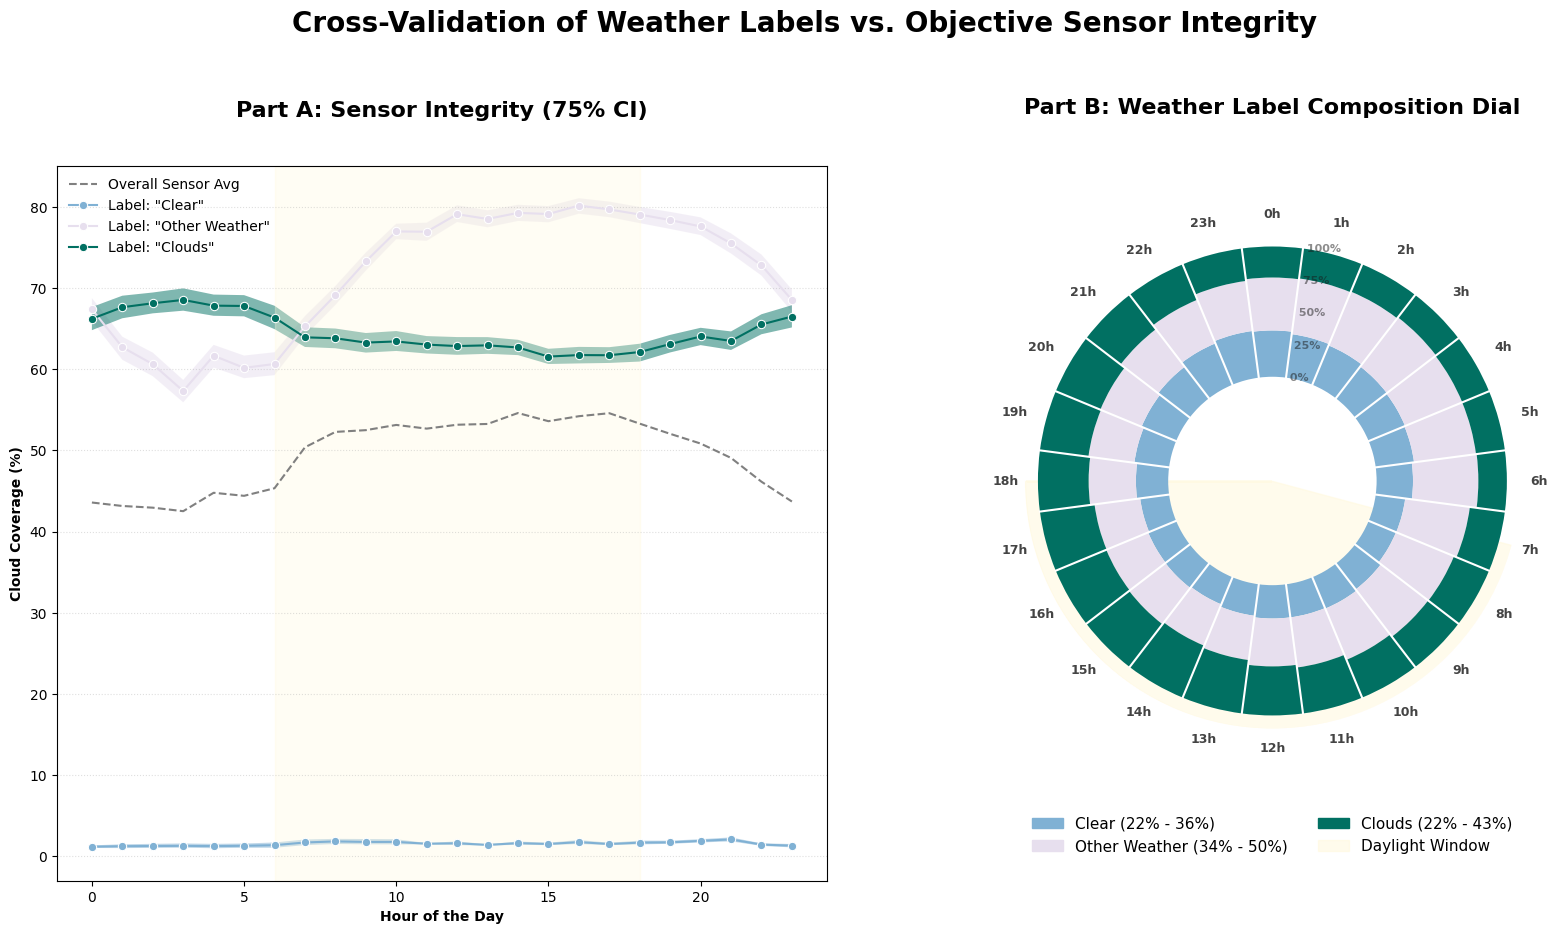

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_final_compact_alignment(df_input):
    """
    Compact & Scientifically Aligned Layout:
    - Bold titles for all subplots and main title.
    - Right plot (Polar) reduced by 0.9x.
    - Reduced white space between subplots.
    - Precise vertical alignment for titles and legend bottom.
    """
    # 1. Data Preparation
    df_temp = df_input.copy()
    df_temp['date_time'] = pd.to_datetime(df_temp['date_time'], dayfirst=True)
    df_temp['hour'] = df_temp['date_time'].dt.hour
    df_temp['weather_grouped'] = df_temp['weather_main'].apply(
        lambda x: x if x in ['Clear', 'Clouds'] else 'Other Weather'
    )

    bias_counts = pd.crosstab(df_temp['hour'], df_temp['weather_grouped'])
    bias_pct = bias_counts.div(bias_counts.sum(1), axis=0)
    stats = {col: (bias_pct[col].min() * 100, bias_pct[col].max() * 100) for col in bias_pct.columns}

    # 2. Synchronized Colors
    cmap = plt.get_cmap('PuBuGn')
    c_clear, c_other, c_clouds = cmap(0.45), cmap(0.15), cmap(0.85)

    # Adjusting overall figure width to reduce blank space
    fig = plt.figure(figsize=(22, 13), facecolor='white')

    # --- DEFINE SHARED COORDINATES ---
    common_bottom = 0.25
    common_height = 0.55

    # --- LEFT SUBPLOT: SENSOR INTEGRITY ---
    ax1 = fig.add_subplot(1, 2, 1)
    # Increased width slightly to balance the smaller polar plot
    ax1.set_position([0.08, common_bottom, 0.35, common_height])

    belt_config = {'alpha': 0.5, 'edgecolor': 'none'}
    sns.lineplot(data=df_temp, x='hour', y='clouds_all', color='gray',
                 linestyle='--', label='Overall Sensor Avg', errorbar=None, ax=ax1)

    for label, color in [('Clear', c_clear), ('Other Weather', c_other), ('Clouds', c_clouds)]:
        sns.lineplot(data=df_temp[df_temp['weather_grouped'] == label],
                     x='hour', y='clouds_all', color=color, marker='o',
                     label=f'Label: "{label}"', ci=75, err_kws=belt_config, ax=ax1)

    # BOLD Title
    ax1.set_title('Part A: Sensor Integrity (75% CI)', fontsize=16, fontweight='bold', pad=35)
    ax1.axvspan(6, 18, color='#fff9db', alpha=0.3)
    ax1.set_ylabel('Cloud Coverage (%)', fontweight='bold')
    ax1.set_xlabel('Hour of the Day', fontweight='bold')
    ax1.legend(loc='upper left', frameon=False, fontsize=10)
    ax1.grid(axis='y', linestyle=':', alpha=0.4)

    # --- RIGHT SUBPLOT: SHRUNK POLAR DIAL (0.9x) ---
    ax2 = fig.add_subplot(1, 2, 2, projection='polar')

    # 0.9x Reduction: width 0.25 -> 0.225 | height 0.55 -> 0.495
    # Centering vertically relative to ax1's middle
    polar_width = 0.225
    polar_height = 0.495
    # Adjusted bottom to keep centers aligned: 0.25 + (0.55-0.495)/2 = 0.2775
    ax2.set_position([0.52, 0.31, polar_width, polar_height])

    inner_radius = 0.8
    bottom = np.full(24, inner_radius)
    angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)
    width = (2 * np.pi) / 24

    for label, color in [('Clear', c_clear), ('Other Weather', c_other), ('Clouds', c_clouds)]:
        heights = bias_pct[label].values
        ax2.bar(angles, heights, width=width, bottom=bottom, color=color, edgecolor='none', zorder=3)
        bottom += heights

    grid_angles = angles + (width / 2)
    for g_angle in grid_angles:
        ax2.plot([g_angle, g_angle], [inner_radius, inner_radius + 1], color='white', linewidth=1.5, zorder=4)

    for r in [0, 0.25, 0.5, 0.75, 1.0]:
        ax2.text(grid_angles[0], inner_radius + r, f' {int(r*100)}%', color='#1a1a1a',
                 fontsize=8, fontweight='black', ha='left', va='center', alpha=0.5, zorder=5)

    ax2.fill_between(np.linspace((7/24)*2*np.pi, (18/24)*2*np.pi, 100), 0, inner_radius+1.1,
                     color='#fff9db', alpha=0.5, zorder=1)

    ax2.set_theta_zero_location('N')
    ax2.set_theta_direction(-1)
    ax2.yaxis.grid(False); ax2.xaxis.grid(False)
    ax2.spines['polar'].set_visible(False)
    ax2.set_xticks(angles)
    ax2.set_xticklabels([f"{i}h" for i in range(24)], fontsize=9, fontweight='bold', color='#444444')
    ax2.set_ylim(0, inner_radius + 1.1)
    ax2.set_yticklabels([])

    # BOLD Title with Compensated Pad for Alignment
    ax2.set_title('Part B: Weather Label Composition Dial', fontsize=16, fontweight='bold', pad=86)

    # --- LEGEND: BOTTOM ALIGNED WITH AX1 BASE ---
    legend_elements = [plt.Rectangle((0,0),1,1, color=color,
                       label=f"{label} ({stats[label][0]:.0f}% - {stats[label][1]:.0f}%)")
                       for label, color in [('Clear', c_clear), ('Other Weather', c_other), ('Clouds', c_clouds)]]
    legend_elements.append(plt.Rectangle((0,0),1,1, color='#fff9db', alpha=0.5, label='Daylight Window'))

    # Adjusted bbox_to_anchor to ensure the bottom of the legend aligns with common_bottom
    ax2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fontsize=11, frameon=False, ncol=2)

    # BOLD Global Title
    plt.suptitle('Cross-Validation of Weather Labels vs. Objective Sensor Integrity',
                 fontsize=20, fontweight='bold', y=0.92, x=0.42)

    plt.show()

plot_final_compact_alignment(df)

# **4. Data Processing**

## 4.1. Step 1: Feature Selection, Anomaly Removal & Holiday Marking

Prompt:

"From the raw dataframe df, select the columns: 'date_time', 'traffic_volume', 'temp', and 'clouds_all'. Filter out rows where 'temp' is 0 Kelvin (sensor errors). Then, using the Python holidays library, create a binary 'is_holiday' column. If a date is a holiday, ensure every hour of that day is marked as 1."

In [ ]:
import pandas as pd
import holidays

# --- 1. Feature Selection & Anomaly Removal ---

# Select only the required columns
selected_features = ['date_time', 'traffic_volume', 'temp', 'clouds_all']
df_minimal = df[selected_features].copy()

# Remove temperature anomalies (0 Kelvin indicates sensor failure)
# We keep only rows where temp is greater than 0
df_minimal = df_minimal[df_minimal['temp'] > 0]

# Convert to datetime format
df_minimal['date_time'] = pd.to_datetime(df_minimal['date_time'], dayfirst=True)

# Sort by time to ensure chronological order
df_minimal = df_minimal.sort_values('date_time')

# --- Holiday Marking ---

# Initialize US holidays (adjust country code if necessary)
us_holidays = holidays.US()

# Function to check if a specific date is a holiday
def check_holiday(x):
    return 1 if x in us_holidays else 0

# Apply holiday logic: map the date (not hour) to the holiday checker
# This ensures every hour of that holiday date gets marked as 1
df_minimal['is_holiday'] = df_minimal['date_time'].dt.date.apply(check_holiday)

print("✅ Step 1 Complete: Features selected, 0K temps removed, and holidays marked.")
print(f"Remaining rows: {len(df_minimal)}")
print(df_minimal.head())
df_minimal.describe()

✅ Step 1 Complete: Features selected, 0K temps removed, and holidays marked.
Remaining rows: 48194
            date_time  traffic_volume    temp  clouds_all  is_holiday
0 2012-10-02 09:00:00            5545  288.28          40           0
1 2012-10-02 10:00:00            4516  289.36          75           0
2 2012-10-02 11:00:00            4767  289.58          90           0
3 2012-10-02 12:00:00            5026  290.13          90           0
4 2012-10-02 13:00:00            4918  291.14          75           0


,date_time,traffic_volume,temp,clouds_all,is_holiday
count,48194,48194.000000,48194.000000,48194.000000,48194.000000
mean,2016-01-05 14:16:20.487197696,3260.221231,281.264219,49.372474,0.032079
min,2012-10-02 09:00:00,0.000000,243.390000,0.000000,0.000000
25%,2014-02-06 19:15:00,1194.000000,272.182500,1.000000,0.000000
50%,2016-06-11 08:30:00,3380.500000,282.460000,64.000000,0.000000
75%,2017-08-11 07:00:00,4933.000000,291.810000,90.000000,0.000000
max,2018-09-30 23:00:00,7280.000000,310.070000,100.000000,1.000000
std,NaN,1986.760420,12.709587,39.013317,0.176211


## 4.2. Step 2: Time Series Repair & Visualization

Prompt:

"Perform rigorous time series restoration on the dataset. First, deduplicate timestamps by averaging and reindex to a strict hourly grid to expose all missing values as NaNs. Second, apply linear interpolation to fill missing values, strictly limiting the repair to gaps of 3 hours or less (leave larger gaps untouched to preserve ground truth). Finally, visualize the structural difference using the 'PuBuGn' colormap: Plot A should show the fragmented Raw Data, and Plot B should show the Restored Data, clearly labeling the 3-hour interpolation logic in the title."

<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1860725848.py:67: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_title('B: Restored Data Structure (Linear Interpolation applied to Gaps $\leq$ 3 Hours)', fontsize=14, fontweight='bold')
/tmp/ipython-input-1860725848.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('PuBuGn')


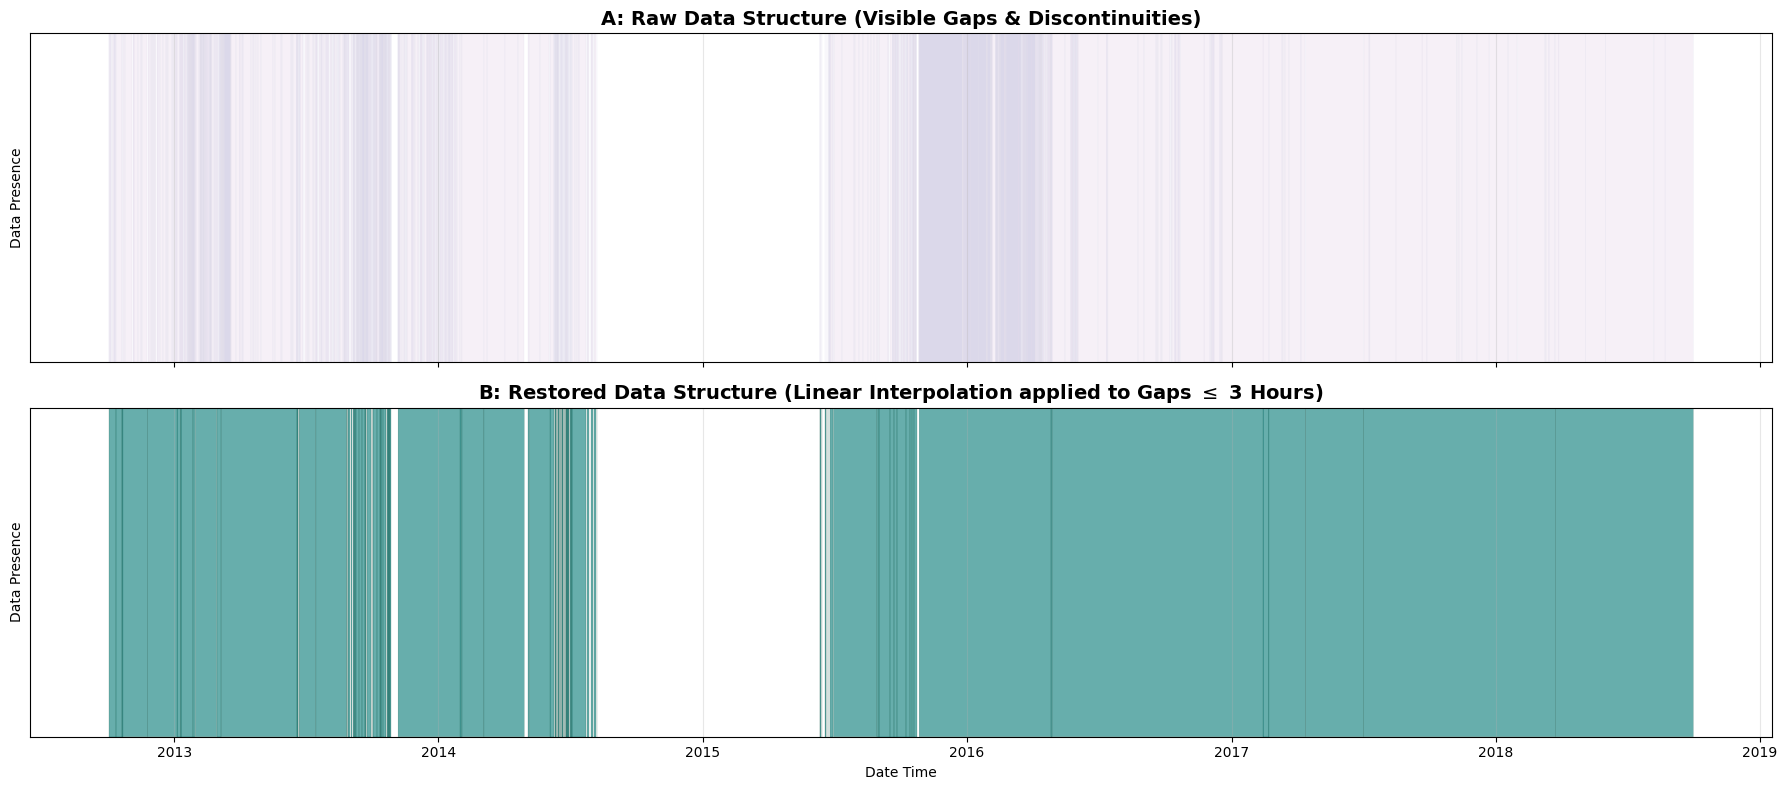

✅ Step 2 Complete: Gaps <= 3h filled. Large gaps preserved.
Hours recovered: 3185


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- 2. Time Series Repair (Deduplicate, Align, Fill Short Gaps) ---

# Handle duplicates: Group by date_time and take the mean
df_dedup = df_minimal.groupby('date_time').mean().sort_index()

# Reindex to force a complete hourly timeline
# This exposes hidden gaps as NaNs
full_range = pd.date_range(start=df_dedup.index.min(),
                           end=df_dedup.index.max(),
                           freq='h')
df_aligned = df_dedup.reindex(full_range)

# Linear Interpolation with a limit of 3 hours
# CRITICAL: Only fill small gaps (<= 3h) to maintain data integrity for larger outages
df_repaired = df_aligned.copy()
features_to_fill = ['traffic_volume', 'temp', 'clouds_all']
df_repaired[features_to_fill] = df_repaired[features_to_fill].interpolate(method='linear', limit=3)

# Fill 'is_holiday' using forward fill
df_repaired['is_holiday'] = df_repaired['is_holiday'].ffill()

# --- Visualization: PuBuGn Progression ---

# Prepare Boolean masks
mask_orig = df_aligned['traffic_volume'].notna().astype(int)
mask_repaired = df_repaired['traffic_volume'].notna().astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

# Define Colors from PuBuGn
cmap = cm.get_cmap('PuBuGn')
color_fill_orig = cmap(0.1)  # Pale Purple-Blue
color_edge_orig = cmap(0.2)
color_fill_repaired = cmap(0.80) # Deep Green
color_edge_repaired = cmap(0.99)

# Styling Constants
linewidth_val = 0.2
alpha_val = 0.6

# Plot A: Raw Data
ax1.fill_between(df_aligned.index, 0, 1,
                 where=mask_orig==1,
                 color=color_fill_orig,
                 edgecolor=color_edge_orig,
                 linewidth=linewidth_val,
                 alpha=alpha_val,
                 transform=ax1.get_xaxis_transform())
# Updated Title: Descriptive and clear
ax1.set_title('A: Raw Data Structure (Visible Gaps & Discontinuities)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Data Presence')
ax1.set_yticks([])
ax1.grid(True, axis='x', alpha=0.3)

# Plot B: Repaired Data
ax2.fill_between(df_repaired.index, 0, 1,
                 where=mask_repaired==1,
                 color=color_fill_repaired,
                 edgecolor=color_edge_repaired,
                 linewidth=linewidth_val,
                 alpha=alpha_val,
                 transform=ax2.get_xaxis_transform())
# Updated Title: Highlights the processing logic
ax2.set_title('B: Restored Data Structure (Linear Interpolation applied to Gaps $\leq$ 3 Hours)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Data Presence')
ax2.set_yticks([])
ax2.set_xlabel('Date Time')
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Step 2 Complete: Gaps <= 3h filled. Large gaps preserved.")
print(f"Hours recovered: {mask_repaired.sum() - mask_orig.sum()}")

In [ ]:
df_repaired.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  43750 non-null  float64
 1   temp            43750 non-null  float64
 2   clouds_all      43750 non-null  float64
 3   is_holiday      52551 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


## 4.3. Step 3: Feature Engineering and Dataset Splitting:

Prompt:

"Please generate Python code for Step 3 of the time series data processing pipeline. This step should focus on Feature Engineering and Logical Dataset Splitting, followed by a comprehensive visualization.

Requirements:

1. Feature Engineering:

    Use df_repaired (from Step 2) as the input.

    Extract hour, day_of_week, and month from the index.

    Apply Cyclical Encoding (Sin/Cos transformations) to these time features to preserve temporal continuity.

    Crucial: Do not drop NaNs yet; keep the full timeline intact.

2. Logical Splitting:

    Define the split indices for a 70% Train, 15% Validation, and 15% Test split based on time.

    Create boolean masks for each set (mask_train, mask_val, mask_test).

    Logic: A data point belongs to a set if and only if: It falls within the time range AND valid data exists in df_repaired (meaning notna()). Large gaps should remain unmasked (empty).

3. Visualization (The 'PuBuGn' Progression):

    Create a 3x1 subplot layout sharing the x-axis.

    Plot A (Raw): Visualize the original data presence (lighter color).

    Plot B (Restored): Visualize the repaired data presence (medium color).

    Plot C (The Split): Visualize the Train/Val/Test split using three distinct, progressive shades of the PuBuGn colormap. This plot should visually demonstrate that large gaps are excluded from all three datasets.

    Place the legend for Plot C below the chart.


<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:85: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-269401534.py:85: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_title('B: Restored Data Structure (Gaps $\leq$ 3h Filled)', fontsize=14, fontweight='bold', loc='left')


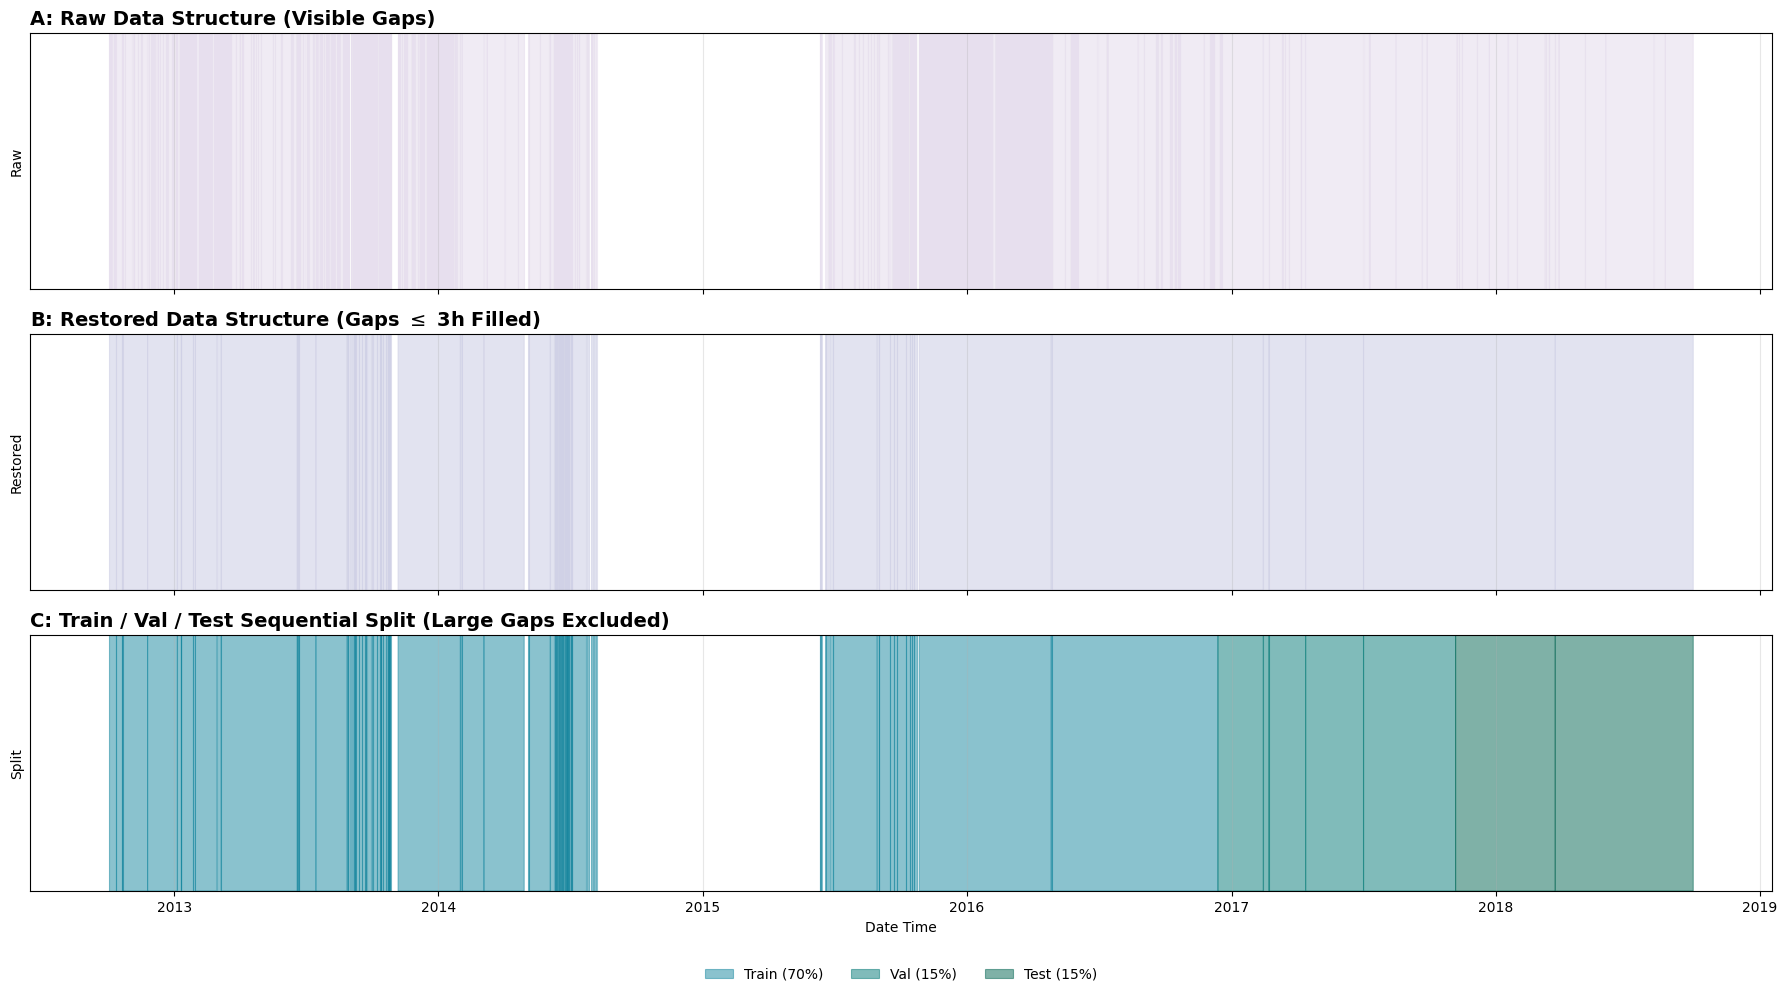

✅ Step 3 Complete: Features Engineered (Hour, Day, Month) & Logic Split Defined.
   - Month features added (sin_month, cos_month).
   - Data ready for Step 4 (No KeyErrors expected).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# ==========================================
# 1. Feature Engineering (Complete Version)
# ==========================================
# Operate on df_repaired to keep the full index intact
df_features = df_repaired.copy()

# A. Extract Time Features
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month

# B. Cyclical Encoding (Hour, Day, AND Month)
# 1. Hour (0-23)
df_features['sin_hour'] = np.sin(2 * np.pi * df_features['hour'] / 24.0)
df_features['cos_hour'] = np.cos(2 * np.pi * df_features['hour'] / 24.0)

# 2. Day of Week (0-6)
df_features['sin_day'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7.0)
df_features['cos_day'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7.0)

# 3. Month (1-12) -> Map to 0-11 for cycle
df_features['sin_month'] = np.sin(2 * np.pi * (df_features['month'] - 1) / 12.0)
df_features['cos_month'] = np.cos(2 * np.pi * (df_features['month'] - 1) / 12.0)

# ==========================================
# 2. Logic Splitting (Define logic only)
# ==========================================
n_total = len(df_features)
idx_train_end = int(n_total * 0.70)
idx_val_end = int(n_total * 0.85)

# Prepare Masks for Visualization
# Logic: Mask = (In Time Range) AND (Data Exists)

# 1. Base Existence Mask (Inherited from Step 2)
mask_repaired = df_repaired['traffic_volume'].notna().astype(int)

# 2. Generate Stage Masks
# Train: 0 ~ 70%
mask_train = mask_repaired.copy()
mask_train.iloc[idx_train_end:] = 0

# Val: 70% ~ 85%
mask_val = mask_repaired.copy()
mask_val.iloc[:idx_train_end] = 0
mask_val.iloc[idx_val_end:] = 0

# Test: 85% ~ End
mask_test = mask_repaired.copy()
mask_test.iloc[:idx_val_end] = 0

# ==========================================
# 3. Visualization (The 'PuBuGn' Progression)
# ==========================================
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

# --- Color Definition ---
cmap = plt.get_cmap('PuBuGn')
color_orig = cmap(0.15)       # Plot A
color_repaired = cmap(0.25)   # Plot B
color_train = cmap(0.7)      # Plot C (Train)
color_val = cmap(0.8)       # Plot C (Val)
color_test = cmap(0.9)       # Plot C (Test)

linewidth_val = 0.8
alpha_val = 0.5

# --- Plot A: Raw Data ---
mask_orig = df_aligned['traffic_volume'].notna().astype(int)
ax1.fill_between(df_aligned.index, 0, 1, where=mask_orig==1,
                 color=color_orig, edgecolor=color_orig, linewidth=linewidth_val, alpha=0.6,
                 transform=ax1.get_xaxis_transform())
ax1.set_title('A: Raw Data Structure (Visible Gaps)', fontsize=14, fontweight='bold', loc='left')
ax1.set_yticks([]); ax1.set_ylabel('Raw'); ax1.grid(True, axis='x', alpha=0.3)

# --- Plot B: Repaired Data ---
ax2.fill_between(df_repaired.index, 0, 1, where=mask_repaired==1,
                 color=color_repaired, edgecolor=color_repaired, linewidth=linewidth_val, alpha=0.6,
                 transform=ax2.get_xaxis_transform())
ax2.set_title('B: Restored Data Structure (Gaps $\leq$ 3h Filled)', fontsize=14, fontweight='bold', loc='left')
ax2.set_yticks([]); ax2.set_ylabel('Restored'); ax2.grid(True, axis='x', alpha=0.3)

# --- Plot C: Dataset Splitting ---
# 1. Train
ax3.fill_between(df_repaired.index, 0, 1, where=mask_train==1, color=color_train, edgecolor=color_train,
                 linewidth=linewidth_val, alpha=alpha_val, transform=ax3.get_xaxis_transform(), label='Train (70%)')
# 2. Val
ax3.fill_between(df_repaired.index, 0, 1, where=mask_val==1, color=color_val, edgecolor=color_val,
                 linewidth=linewidth_val, alpha=alpha_val, transform=ax3.get_xaxis_transform(), label='Val (15%)')
# 3. Test
ax3.fill_between(df_repaired.index, 0, 1, where=mask_test==1, color=color_test, edgecolor=color_test,
                 linewidth=linewidth_val, alpha=alpha_val, transform=ax3.get_xaxis_transform(), label='Test (15%)')

ax3.set_title('C: Train / Val / Test Sequential Split (Large Gaps Excluded)', fontsize=14, fontweight='bold', loc='left')
ax3.set_yticks([]); ax3.set_ylabel('Split'); ax3.set_xlabel('Date Time'); ax3.grid(True, axis='x', alpha=0.3)
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, frameon=False)

plt.tight_layout()
plt.show()

print("✅ Step 3 Complete: Features Engineered (Hour, Day, Month) & Logic Split Defined.")
print("   - Month features added (sin_month, cos_month).")
print("   - Data ready for Step 4 (No KeyErrors expected).")

In [ ]:
df_repaired.info()
df_repaired.describe()
df_features.info()
df_features.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  43750 non-null  float64
 1   temp            43750 non-null  float64
 2   clouds_all      43750 non-null  float64
 3   is_holiday      52551 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Freq: h
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  43750 non-null  float64
 1   temp            43750 non-null  float64
 2   clouds_all      43750 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   hour            52551 non-null  int32  
 5   day_of_week     52551 non-null  int32  
 6   month           52551 

,traffic_volume,temp,clouds_all,is_holiday,hour,day_of_week,month,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month
count,43750.000000,43750.000000,43750.000000,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000,5.255100e+04,52551.000000,52551.000000,52551.000000,5.255100e+04
mean,3304.293776,281.161937,44.515868,0.025556,11.501284,3.001713,6.521779,-0.000117,-6.734521e-05,-0.000134,-0.000563,-0.002618,-4.350644e-03
std,1974.083091,13.010072,38.630927,0.157808,6.922067,1.999447,3.448434,0.707104,7.071227e-01,0.707261,0.706965,0.706806,7.074028e-01
min,0.000000,243.390000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969,-1.000000,-1.000000e+00
25%,1305.125000,271.751250,1.000000,0.000000,6.000000,1.000000,4.000000,-0.707107,-7.071068e-01,-0.781831,-0.900969,-0.500000,-8.660254e-01
50%,3455.000000,282.260000,40.000000,0.000000,12.000000,3.000000,7.000000,0.000000,-1.836970e-16,0.000000,-0.222521,0.000000,-1.836970e-16
75%,4961.000000,292.060000,90.000000,0.000000,18.000000,5.000000,10.000000,0.707107,7.071068e-01,0.781831,0.623490,0.866025,5.000000e-01
max,7280.000000,310.070000,100.000000,1.000000,23.000000,6.000000,12.000000,1.000000,1.000000e+00,0.974928,1.000000,1.000000,1.000000e+00


## 4.4 Step 4: Data Preprocessing for Deep Learning

Prompt:

Input: Use the df_features DataFrame and the boolean masks (mask_train, mask_val, mask_test) generated in Step 3.

Requirements:

1. Segmentation Strategy: Before dropping any data, generate a segment_id column on the full dataset. This ID should increment whenever a gap (NaN) is encountered. This allows us to track discontinuities.

2. Physical Extraction: Use the Step 3 masks to extract three separate clean DataFrames (train_df, val_df, test_df). This action physically removes the NaNs (gaps).

3. Data Scaling (No Leakage):

    Initialize a MinMaxScaler.

    Important: Fit the scaler only on train_df feature columns.

    Transform train_df, val_df, and test_df using this fitted scaler.

4. Safe Windowing Function:

    Create a function create_dataset(data, window_size) to generate (X, y) tensors for an RNN/LSTM.

5. Constraint: The function must strictly check segment_id. A window should only be created if the segment_id at the start of the window matches the segment_id at the end (ensuring the window is contiguous in time).

Output: Generate the final X_train, y_train, X_val, y_val, X_test, and y_test arrays and print their shapes."

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm # Progress bar

# ==========================================
# 1. Global Pre-processing (Segmentation)
# ==========================================
# We must generate 'segment_id' BEFORE dropping NaNs to mark where gaps exist.
# A change in segment_id implies a discontinuity in time.
df_step4 = df_features.copy() # From Step 3
df_step4['is_gap'] = df_step4['traffic_volume'].isna().astype(int)
df_step4['segment_id'] = df_step4['is_gap'].cumsum()

# ==========================================
# 2. Physical Splitting & NaN Removal
# ==========================================
# We use the boolean masks created in Step 3 to extract clean datasets.
# Logic: mask == 1 implies (Time is correct) AND (Data is not NaN)
train_df = df_step4[mask_train == 1].copy()
val_df = df_step4[mask_val == 1].copy()
test_df = df_step4[mask_test == 1].copy()

# Drop the helper column 'is_gap' (no longer needed)
train_df.drop(columns=['is_gap'], inplace=True)
val_df.drop(columns=['is_gap'], inplace=True)
test_df.drop(columns=['is_gap'], inplace=True)

print(f"Step 4.1: Data Extracted.")
print(f"Train Rows: {len(train_df)} | Val Rows: {len(val_df)} | Test Rows: {len(test_df)}")

# ==========================================
# 3. Feature Scaling (Normalization)
# ==========================================
# CRITICAL: Fit scaler ONLY on Training data to prevent Data Leakage.
# We normalize continuous features to range [0, 1].

# Define features
feature_cols = [
    'traffic_volume', 'temp', 'clouds_all',
    'is_holiday',
    'sin_hour', 'cos_hour',
    'sin_day', 'cos_day',
    'sin_month', 'cos_month'
]
# Note: 'segment_id' is NOT a feature, it's a structural helper.

scaler = MinMaxScaler()

# 1. Fit on Train
scaler.fit(train_df[feature_cols])

# 2. Transform All
train_df[feature_cols] = scaler.transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("Step 4.2: Scaling Complete (Fit on Train, Transformed Val/Test).")

# ==========================================
# 4. Safe Sliding Window Generation
# ==========================================

def create_dataset(data, window_size, horizon=1):
    """
    Generates (X, y) pairs using a sliding window.
    Crucially, it checks 'segment_id' to prevent windows from crossing data gaps.
    """
    X, y = [], []

    # Convert to numpy for performance
    # data_arr contains all features including segment_id
    # We assume 'segment_id' is the last column or we access it by name if possible.
    # To be safe, let's extract columns explicitly.

    features_data = data[feature_cols].values
    target_data = data['traffic_volume'].values # Assuming we predict traffic_volume
    segment_ids = data['segment_id'].values

    # Iterate
    # range logic: we need 'window_size' past steps + 'horizon' future step
    for i in range(window_size, len(data) - horizon + 1):

        # SAFETY CHECK:
        # The segment_id at the start of the window must match the segment_id at the end.
        # If they differ, it means this window spans across a deleted gap.
        current_segment = segment_ids[i]
        start_segment = segment_ids[i - window_size]

        if current_segment == start_segment:
            # Extract Window (Past N hours)
            # Shape: (window_size, n_features)
            X.append(features_data[i-window_size : i])

            # Extract Target (Next hour)
            # Shape: (1,)
            y.append(target_data[i + horizon - 1])

    return np.array(X), np.array(y)

# Hyperparameters
WINDOW_SIZE = 24  # Look back 24 hours
FORECAST_HORIZON = 1

# Generate Tensors
X_train, y_train = create_dataset(train_df, WINDOW_SIZE, FORECAST_HORIZON)
X_val, y_val = create_dataset(val_df, WINDOW_SIZE, FORECAST_HORIZON)
X_test, y_test = create_dataset(test_df, WINDOW_SIZE, FORECAST_HORIZON)

# ==========================================
# 5. Final Shape Verification
# ==========================================
print("-" * 30)
print(f"✅ Step 4 Complete: Tensors Ready for RNN/LSTM.")
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}   | y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}  | y_test shape:  {y_test.shape}")
print("-" * 30)

Step 4.1: Data Extracted.
Train Rows: 28001 | Val Rows: 7869 | Test Rows: 7880
Step 4.2: Scaling Complete (Fit on Train, Transformed Val/Test).
------------------------------
✅ Step 4 Complete: Tensors Ready for RNN/LSTM.
X_train shape: (26105, 24, 10) | y_train shape: (26105,)
X_val shape:   (7749, 24, 10)   | y_val shape:   (7749,)
X_test shape:  (7832, 24, 10)  | y_test shape:  (7832,)
------------------------------


In [ ]:
print("X_train shape:", X_train.shape)

X_train shape: (26105, 24, 10)


In [ ]:
print("Train Max:", X_train.max(), "| Train Min:", X_train.min())
print("Val Max:  ", X_val.max(),   "| Val Min:  ", X_val.min())

Train Max: 1.0000000000000004 | Train Min: 0.0
Val Max:   1.002754820936639 | Val Min:   -0.022548092084516025


# **5. Model Training**

## 5.1. Step 6: Model Training & Tuning

Prompt:

The primary objective of this phase is to train a SimpleRNN forecasting model and evaluate its performance across eight independent experiments by varying the number of hidden units, learning rate, and dropout rate.

1. Training Setup

    Input Data: The model utilizes preprocessed 24-hour multivariate observation windows, specifically X_train, y_train, X_val, and y_val.

    Network Architecture: The pipeline consists of an Input layer, a single SimpleRNN layer (for temporal dependencies), a Dropout layer (for regularization), and a Dense output layer (for next-step prediction).

    Loss and Optimization: Mean Squared Error (MSE) is employed as the loss function, optimized using the Adam optimizer.

    Execution Details: Training is conducted with a fixed batch size of 64 for a maximum of 60 epochs.

    Convergence Control: An Early Stopping callback monitors validation loss with a patience of 20 epochs, automatically restoring the best performing weights.


2. Ablation Study Design
    A systematic ablation study is performed by varying three core dimensions across eight controlled experiments to find the optimal configuration:

    RNN Units: Testing 32 vs. 64 units to compare model capacity.

    Learning Rate: Evaluating the impact of 0.0005, 0.001, and 0.005 on convergence stability.

    Dropout Rate: Testing rates of 0.0, 0.1, 0.2, and 0.5 to determine the optimal level of regularization.

3. Output and Documentation

    Model Persistence: Each trained model is saved in .keras format to ensure reproducibility and allow for future evaluation.


    History Recording: Full validation loss histories are captured for every experiment to analyze and compare convergence patterns.

    Data Serialization: Final training results are serialized into a .pkl file for downstream benchmarking and visualization scripts.

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ==========================================
# 0. Environment Check
# ==========================================
# We assume X_train, y_train, X_val, y_val are already in memory.
required_vars = ['X_train', 'y_train', 'X_val', 'y_val']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    raise ValueError(f"❌ Missing variables: {missing_vars}. Please run your pre-processing code first!")

print(f"✅ Data detected!")
print(f"   Train Input: {X_train.shape}")
print(f"   Val Input:   {X_val.shape}")

# Define Input Shape dynamically based on your data
# (Should be (24, 10) based on your window_size=24 and 10 features)
INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

if 'BASE_DIR' not in locals():
    BASE_DIR = '.'
SAVE_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(SAVE_DIR, exist_ok=True)

# ==========================================
# 1. Define Training Function
# ==========================================
def train_experiment(name, units, dropout_rate, learning_rate, epochs=60):
    print(f"\n🧪 Experiment: {name}")
    print(f"   [Config] Units={units} | Drop={dropout_rate} | LR={learning_rate}")

    # Build Model using the existing input shape
    model = Sequential([
        Input(shape=INPUT_SHAPE),
        SimpleRNN(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Early Stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train using the global X_train/X_val variables
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0  # Silent training
    )

    # Save Model
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "")
    model.save(os.path.join(SAVE_DIR, f"{safe_name}.keras"))

    # Log Results
    best_score = min(history.history['val_loss'])
    print(f"   ⏱️ Stopped at Epoch: {len(history.history['val_loss'])}/{epochs}")
    print(f"   🏆 Best Val Loss: {best_score:.5f}")

    return history.history['val_loss']

# ==========================================
# 2. Execution Loop
# ==========================================
results = {}

def run_and_record(key, *args, **kwargs):
    loss_history = train_experiment(key, *args, **kwargs)
    results[key] = loss_history

print("🚀 Starting Comprehensive Benchmark (60 Epochs)...")

# --- Run the 8 Experiments ---
run_and_record('1. Baseline (64u, D=0.2, LR=1e-3)', 64, 0.2, 0.001, epochs=60)
run_and_record('2. Light (32u, D=0.2, LR=1e-3)', 32, 0.2, 0.001, epochs=60)
run_and_record('3. High LR (64u, D=0.2, LR=5e-3)', 64, 0.2, 0.005, epochs=60)
run_and_record('4. Low LR (64u, D=0.2, LR=5e-4)', 64, 0.2, 0.0005, epochs=60)
run_and_record('5. High Drop (64u, D=0.5, LR=1e-3)', 64, 0.5, 0.001, epochs=60)
run_and_record('6. No Drop (64u, D=0.0, LR=1e-3)', 64, 0.0, 0.001, epochs=60)
run_and_record('7. Light NoDrop (32u, D=0.0, LR=1e-3)', 32, 0.0, 0.001, epochs=60)
run_and_record('8. Mild Drop (64u, D=0.1, LR=1e-3)', 64, 0.1, 0.001, epochs=60)

print("\n🎉 All experiments finished!")

# ==========================================
# 3. Save Data for Plotting
# ==========================================
results_path = os.path.join(BASE_DIR, 'data', 'final_results_data.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

print(f"💾 Plotting data saved to: {results_path}")
print("👉 You can now run the PuBuGn plotting script!")

✅ Data detected!
   Train Input: (26105, 24, 10)
   Val Input:   (7749, 24, 10)
🚀 Starting Comprehensive Benchmark (60 Epochs)...

🧪 Experiment: 1. Baseline (64u, D=0.2, LR=1e-3)
   [Config] Units=64 | Drop=0.2 | LR=0.001
   ⏱️ Stopped at Epoch: 60/60
   🏆 Best Val Loss: 0.00131

🧪 Experiment: 2. Light (32u, D=0.2, LR=1e-3)
   [Config] Units=32 | Drop=0.2 | LR=0.001
   ⏱️ Stopped at Epoch: 60/60
   🏆 Best Val Loss: 0.00132

🧪 Experiment: 3. High LR (64u, D=0.2, LR=5e-3)
   [Config] Units=64 | Drop=0.2 | LR=0.005
   ⏱️ Stopped at Epoch: 60/60
   🏆 Best Val Loss: 0.00147

🧪 Experiment: 4. Low LR (64u, D=0.2, LR=5e-4)
   [Config] Units=64 | Drop=0.2 | LR=0.0005
   ⏱️ Stopped at Epoch: 60/60
   🏆 Best Val Loss: 0.00127

🧪 Experiment: 5. High Drop (64u, D=0.5, LR=1e-3)
   [Config] Units=64 | Drop=0.5 | LR=0.001
   ⏱️ Stopped at Epoch: 60/60
   🏆 Best Val Loss: 0.00136

🧪 Experiment: 6. No Drop (64u, D=0.0, LR=1e-3)
   [Config] Units=64 | Drop=0.0 | LR=0.001
   ⏱️ Stopped at Epoch: 60/60
   

## 5.2. Step 7: Ablation Study Visualization

Prompt:

The primary objective of this step is to visualize the convergence patterns of all eight experimental configurations. By plotting the validation loss curves, we can identify the "champion" model and analyze how different hyperparameters influenced the training stability.

1. Visualization Logic

    Metric Extraction: The script identifies the absolute minimum loss (np.min) achieved by each model across all epochs.


    Ranking and Layering: Models are ranked by performance. Better-performing models are plotted with darker colors and higher z-order to ensure the most important results are visible on top.


    Color Mapping: A gradient from the PuBuGn colormap is used to represent the progression from baseline configurations (lighter) to the optimal model (darkest).

2. Styling and Interactivity

    Dynamic Legend: Each curve in the legend is labeled with its specific configuration and the best validation MSE achieved.

    Clean Layout: The plot uses a clean aesthetic by removing top/right spines and utilizing a dashed grid for better readability of the MSE values.

    Persistence: The visualization relies on the serialized .pkl data generated in the previous step, ensuring the results can be analyzed independently of the training process.

✅ Data loaded successfully


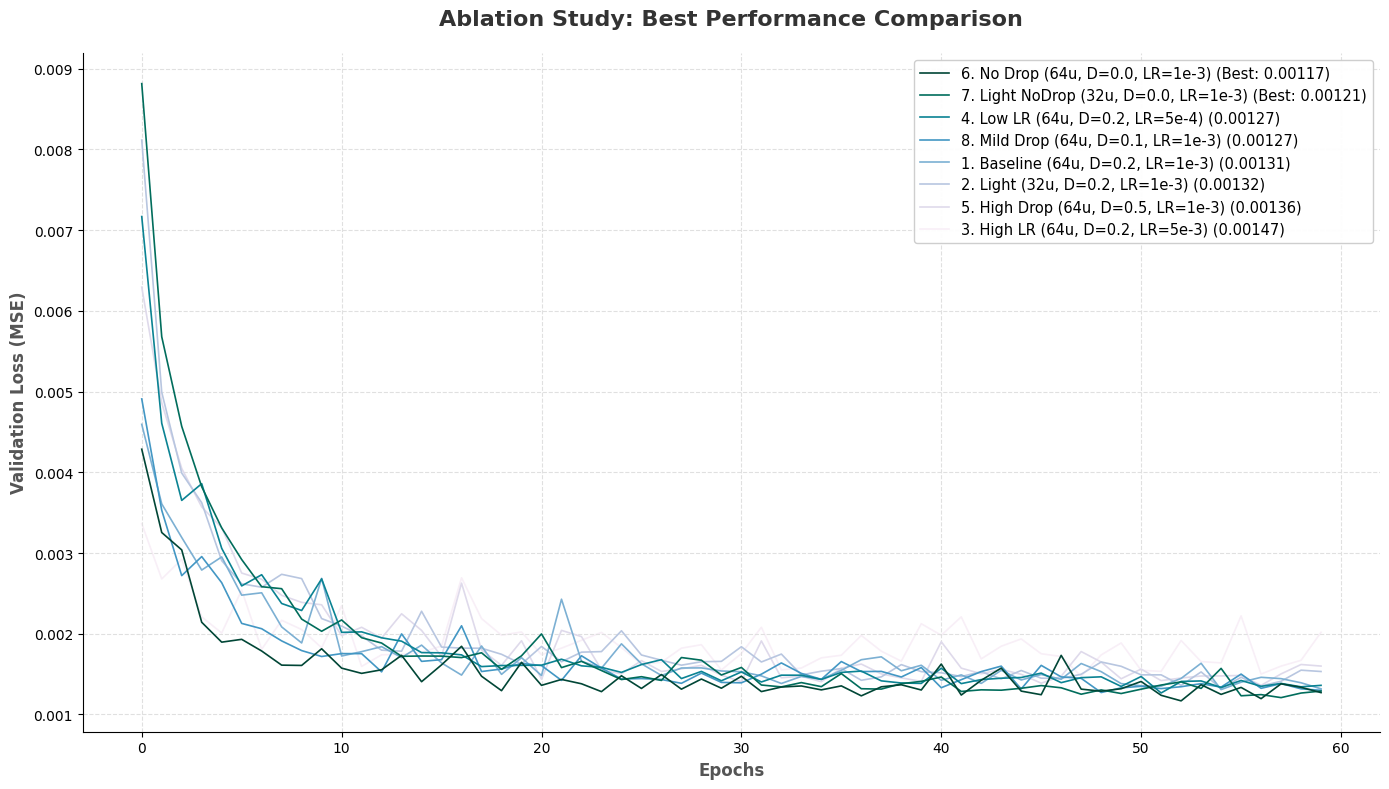

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

# ==========================================
# 1. Load Data
# ==========================================
# Ensure BASE_DIR is defined, otherwise default to current directory
if 'BASE_DIR' not in locals():
    BASE_DIR = '.'

file_path = os.path.join(BASE_DIR, 'data', 'final_results_data.pkl')

if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        results = pickle.load(f)
    print("✅ Data loaded successfully")
else:
    # If file not found, try using in-memory variable (if training just finished)
    if 'results' not in locals():
        results = {}
    print("⚠️ Using in-memory 'results' variable")

if results:
    # ==========================================
    # 2. Core Fix: Use min() instead of mean()
    # ==========================================
    # Logic update: Find the absolute minimum loss achieved by each model
    best_losses = {name: np.min(curve) for name, curve in results.items()}

    # Sort: Rank by lowest loss (Best Loss)
    # reverse=True ensures the best (lowest loss) comes last in the list for plotting layers
    sorted_items = sorted(best_losses.items(), key=lambda x: x[1], reverse=True)
    sorted_names = [item[0] for item in sorted_items]

    # Colors: Generate gradient from Light (0.35) to Dark (1.0)
    num_lines = len(results)
    colors = cm.PuBuGn(np.linspace(0.05, 1.0, num_lines))

    # ==========================================
    # 3. Plotting
    # ==========================================
    plt.figure(figsize=(14, 8))

    for i, name in enumerate(sorted_names):
        loss_curve = results[name]
        best_val = best_losses[name] # Get best value
        color = colors[i]

        # Dynamic Legend & Z-Order
        # Higher i = Better performance = Darker color = Top layer
        if i == num_lines - 1: # 1st Place (Champion)
            label = f"{name} (Best: {best_val:.5f})"
            zorder = 10
        elif i == num_lines - 2: # 2nd Place (Runner-up)
            label = f"{name} (Best: {best_val:.5f})"
            zorder = 9
        else:
            label = f"{name} ({best_val:.5f})"
            zorder = i + 1

        plt.plot(loss_curve, label=label, color=color, linewidth=1.2, alpha=1, zorder=zorder)

    # ==========================================
    # 4. Styling
    # ==========================================
    plt.title('Ablation Study: Best Performance Comparison', fontsize=16, pad=20, fontweight='bold', color='#333333')
    plt.xlabel('Epochs', fontsize=12, fontweight='bold', color='#555555')
    plt.ylabel('Validation Loss (MSE)', fontsize=12, fontweight='bold', color='#555555')
    plt.grid(True, which='major', color='#E0E0E0', linestyle='--', linewidth=0.8)

    # Remove top and right spines for a cleaner look
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Reverse legend order (Best model on top)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize=10.5, loc='upper right', frameon=True, framealpha=0.95)

    plt.tight_layout()
    plt.show()
else:
    print("❌ No results data found to plot.")

# **6. Evaluation**

## 6.1. Evaluation on Test Set

The goal is to evaluate the model on the held-out Test Set and quantify the performance gain provided by sequential modeling.

1. Baseline
Linear Regression: Used as the simplest baseline to establish a performance floor. It processes a flattened version of the 24-hour input.

    a.Linear Regression

    b.FCNN (MLP): A non-sequential baseline with a comparable parameter count to ensure a fair comparison.

    c.SimpleRNN: The final model selected from the ablation study (64 units, no dropout).

2. Evaluation Logic

    Inverse Transformation: All error metrics (RMSE and MAE) are calculated after scaling the predictions back to the original traffic volume units. This ensures the results reflect the actual car count deviation.

3. Performance Visualization

    Metrics Comparison: A dual-bar chart is generated to compare RMSE and MAE across the three models.

    Color Scheme: Consistent with the project's visual style, a PuBuGn gradient is applied, where darker shades correspond to the more sophisticated architecture and improved error reduction.

    Final Results: The script calculates the error reduction percentage to show the impact of the sequential RNN approach compared to traditional flattened methods.

ℹ️ Detected Features: 10

🚀 Training Linear Regression...
📊 Linear Regression Performance: RMSE=373.72 | MAE=251.23

🚀 Training FCNN (Standard Funnel: 32->8)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 FCNN (Standard) Performance: RMSE=272.09 | MAE=190.15

🚀 Loading Best RNN Model from Disk...
✅ Successfully loaded: /content/drive/MyDrive/CA6000_Assignment_WANGHaocheng/models/6._No_Drop_64u_D=0.0_LR=1e-3.keras
   RNN Params: 4865
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
📊 Vanilla RNN (Best Saved) Performance: RMSE=240.69 | MAE=158.71


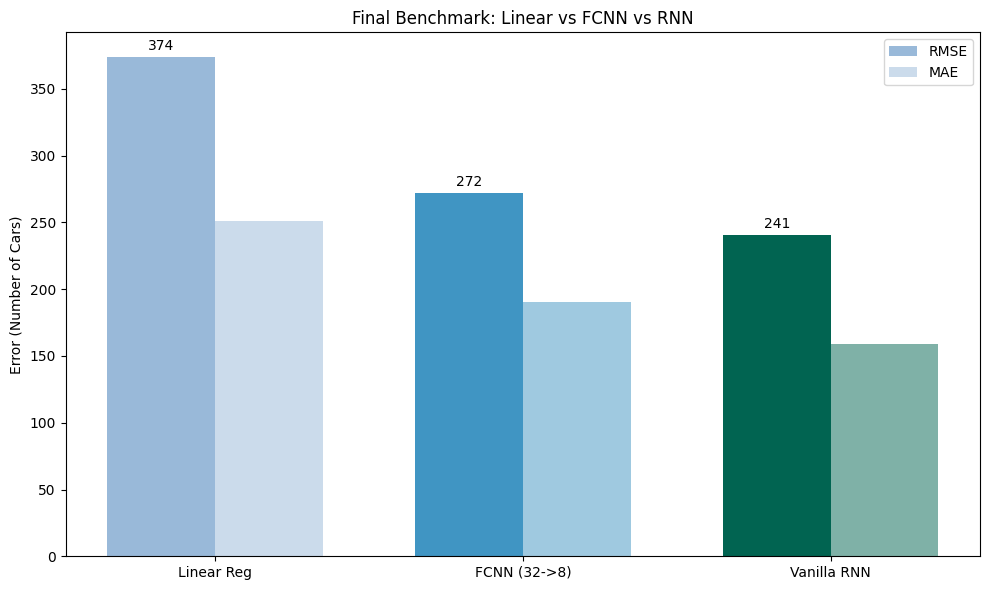

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input

# ==========================================
# 0. Data Preparation & Helper
# ==========================================
# Flatten for LR and FCNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Dynamic feature count detection
NUM_FEATURES = X_test.shape[2] # Should be 10 now
print(f"ℹ️ Detected Features: {NUM_FEATURES}")

def evaluate_model(predictions, name):
    # Create dummy array with correct shape (N, 10)
    dummy_pred = np.zeros((len(predictions), NUM_FEATURES))

    # Assuming 'traffic_volume' is at index 0 (based on feature_cols order)
    dummy_pred[:, 0] = predictions.flatten()

    # Inverse Transform
    pred_real = scaler.inverse_transform(dummy_pred)[:, 0]

    # Do the same for Ground Truth
    dummy_true = np.zeros((len(y_test), NUM_FEATURES))
    dummy_true[:, 0] = y_test.flatten()
    y_test_real = scaler.inverse_transform(dummy_true)[:, 0]

    rmse = np.sqrt(mean_squared_error(y_test_real, pred_real))
    mae = mean_absolute_error(y_test_real, pred_real)
    print(f"📊 {name} Performance: RMSE={rmse:.2f} | MAE={mae:.2f}")
    return rmse, mae

# ==========================================
# 1. Linear Regression (The Floor)
# ==========================================
print("\n🚀 Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
lr_pred = lr_model.predict(X_test_flat)
rmse_lr, mae_lr = evaluate_model(lr_pred, "Linear Regression")

# ==========================================
# 2. FCNN (The "Generous" Baseline)
# ==========================================
print("\n🚀 Training FCNN (Standard Funnel: 32->8)...")
# Note: Input shape is flattened (24 * 10 = 240)
fcnn_model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])
fcnn_model.compile(optimizer='adam', loss='mse')
fcnn_model.fit(X_train_flat, y_train, epochs=40, batch_size=64, verbose=0)
fcnn_pred = fcnn_model.predict(X_test_flat)
rmse_fcnn, mae_fcnn = evaluate_model(fcnn_pred, "FCNN (Standard)")

# ==========================================
# 3. Vanilla RNN (Load The Champion!)
# ==========================================
print("\n🚀 Loading Best RNN Model from Disk...")

# Define the path to your best model (e.g., Exp 6 No Drop or the Best one)
# Please check your file list for the exact name. It usually looks like this:
best_model_path = os.path.join(SAVE_DIR, '6._No_Drop_64u_D=0.0_LR=1e-3.keras')

try:
    rnn_model = load_model(best_model_path)
    print(f"✅ Successfully loaded: {best_model_path}")
    print(f"   RNN Params: {rnn_model.count_params()}")

    # Predict directly
    rnn_pred = rnn_model.predict(X_test)
    rmse_rnn, mae_rnn = evaluate_model(rnn_pred, "Vanilla RNN (Best Saved)")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("   Please check the filename in your 'models' folder.")
    # Fallback: Set dummy values so plotting doesn't crash
    rmse_rnn, mae_rnn = 0, 0

# ==========================================
# 4. Visualization
# ==========================================
models = ['Linear Reg', 'FCNN (32->8)', 'Vanilla RNN']
rmses = [rmse_lr, rmse_fcnn, rmse_rnn]
maes = [mae_lr, mae_fcnn, mae_rnn]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
# Colors: Light -> Medium -> Dark (Visualizing Improvement)
cmap = plt.get_cmap('PuBuGn')
colors = [cmap(0.4), cmap(0.6), cmap(0.9)]

rects1 = ax.bar(x - width/2, rmses, width, label='RMSE', color=colors)
rects2 = ax.bar(x + width/2, maes, width, label='MAE', color=colors, alpha=0.5)

ax.set_ylabel('Error (Number of Cars)')
ax.set_title('Final Benchmark: Linear vs FCNN vs RNN')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.0f')

plt.tight_layout()
plt.show()

## 6.2. Evaluation & Benchmark Visualization

Evaluate the trained models (RNN, FCNN, and Linear Regression) on the test set and compare their prediction accuracy over a standard week. Generate both numerical metrics (RMSE, MAE) and visualizations to illustrate performance.

For visualization, plot two panels side by side:

1. Bar chart comparing RMSE and MAE for all three models.

2. Time series plot showing the predicted traffic vs. ground truth for one full week, ideally starting from Monday. Include daily separators and day labels.

Additionally, add a zoomed-in inset focusing on the morning rush hours to highlight how well each model captures peak traffic. Use clear, distinguishable colors for each model and ensure the plots are easy to interpret.

Make sure to handle inverse scaling of the predicted values to match the original traffic volume units. This analysis should help assess which model best tracks daily and weekly traffic patterns.

🔄 Generating predictions for all models...
✅ Predictions ready.
🎯 Selected Week Start Index: 131


/tmp/ipython-input-3720395041.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


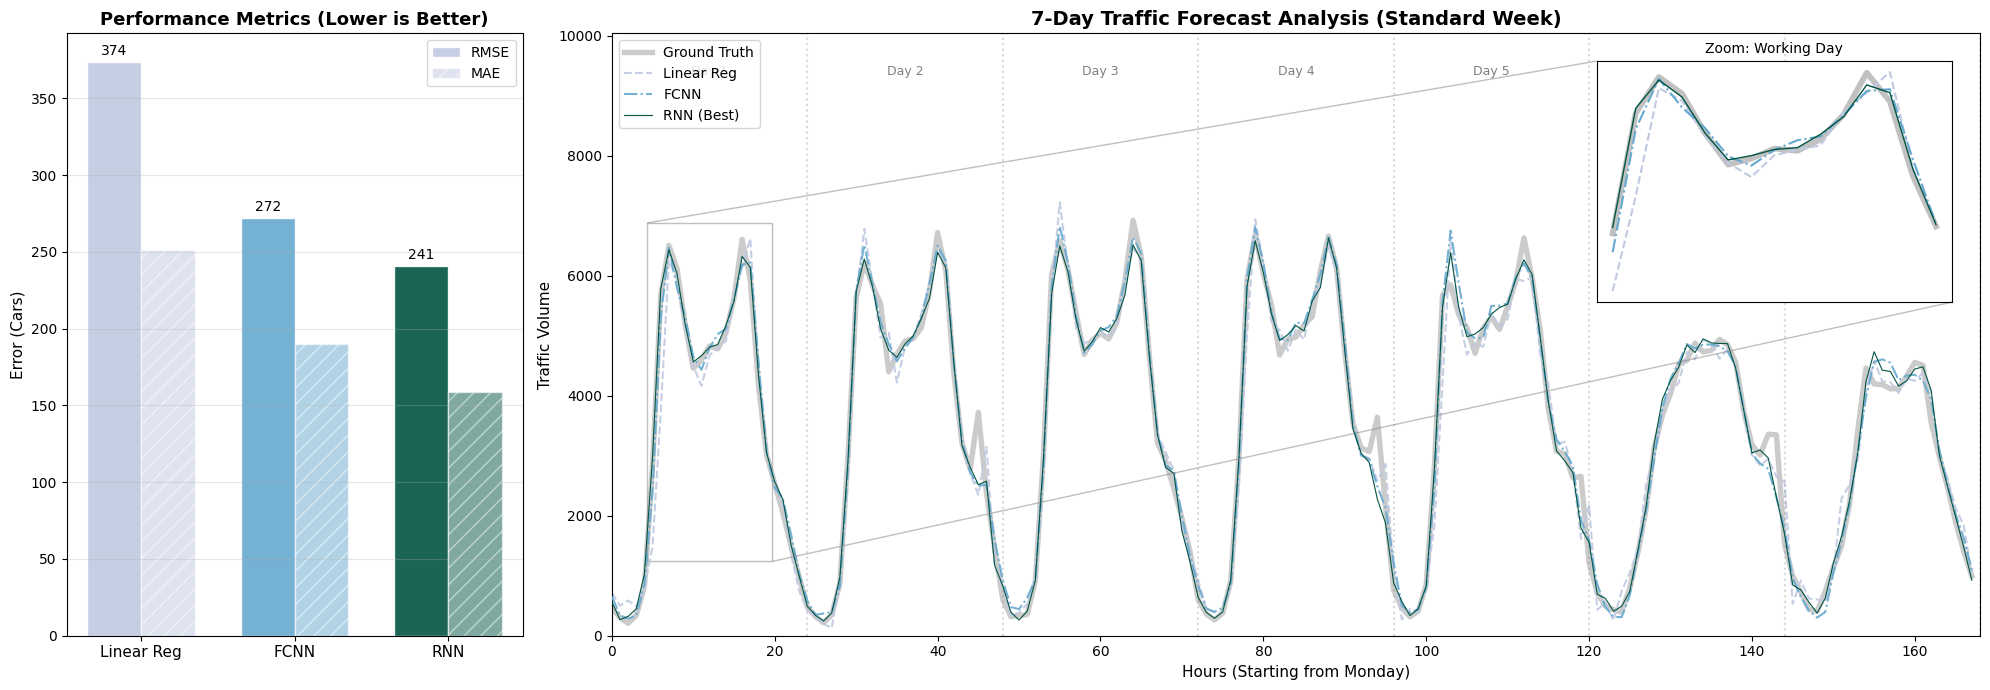

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm  #colormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==========================================
# 0. Data Preparation
# ==========================================
print("🔄 Generating predictions for all models...")

# Helper function: Handle inverse scaling for 10 features
def inverse_y(y_arr):
    dummy = np.zeros((len(y_arr), 10))
    dummy[:, 0] = y_arr.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

# 1. Ground Truth
y_real = inverse_y(y_test)

# 2. Linear Regression
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_pred_lr_raw = lr_model.predict(X_test_flat)
y_pred_lr = inverse_y(y_pred_lr_raw)

# 3. FCNN
y_pred_fcnn_raw = fcnn_model.predict(X_test_flat, verbose=0)
y_pred_fcnn = inverse_y(y_pred_fcnn_raw)

# 4. RNN
y_pred_rnn_raw = rnn_model.predict(X_test, verbose=0)
y_pred_rnn = inverse_y(y_pred_rnn_raw)

# Calculate Metrics
rmse_lr = np.sqrt(mean_squared_error(y_real, y_pred_lr))
mae_lr = mean_absolute_error(y_real, y_pred_lr)
rmse_fcnn = np.sqrt(mean_squared_error(y_real, y_pred_fcnn))
mae_fcnn = mean_absolute_error(y_real, y_pred_fcnn)
rmse_rnn = np.sqrt(mean_squared_error(y_real, y_pred_rnn))
mae_rnn = mean_absolute_error(y_real, y_pred_rnn)

print("✅ Predictions ready.")

# ==========================================
# 0.5 Alignment：Find a week's start
# ==========================================
test_timestamps = test_df.index[24:]
monday_indices = np.where((test_timestamps.dayofweek == 0) & (test_timestamps.hour == 0))[0]

best_start_index = 0
if len(monday_indices) > 0:
    for idx in monday_indices[:10]:
        if idx + 168 > len(y_real): break
        week_data = y_real[idx : idx + 168]
        if np.mean(week_data[:120]) > np.mean(week_data[120:]) * 1.2:
            best_start_index = idx
            break
else:
    print("⚠️ No Monday start found, using index 0.")

print(f"🎯 Selected Week Start Index: {best_start_index}")

s, e = best_start_index, best_start_index + 168
y_real_s = y_real[s:e]
y_lr_s = y_pred_lr[s:e]
y_fcnn_s = y_pred_fcnn[s:e]
y_rnn_s = y_pred_rnn[s:e]

# ==========================================
# 1. Plot Config (PuBuGn cmap)
# ==========================================
cmap = plt.get_cmap('PuBuGn')

# def color (Light -> Dark)
c_real = '#333333'
c_lr   = cmap(0.3)
c_fcnn = cmap(0.5)
c_rnn  = cmap(0.95)

model_colors = [c_lr, c_fcnn, c_rnn]
models_names = ['Linear Reg', 'FCNN', 'RNN']
rmses = [rmse_lr, rmse_fcnn, rmse_rnn]
maes = [mae_lr, mae_fcnn, mae_rnn]

fig, axes = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1, 3]})
ax_bar = axes[0]
ax_ts = axes[1]

# ==========================================
# 2. Left：Bar Chart
# ==========================================
x = np.arange(3)
width = 0.35
rects1 = ax_bar.bar(x - width/2, rmses, width, label='RMSE', color=model_colors, alpha=0.9, edgecolor='white')
rects2 = ax_bar.bar(x + width/2, maes, width, label='MAE', color=model_colors, alpha=0.5, hatch='//', edgecolor='white')

ax_bar.set_ylabel('Error (Cars)', fontsize=11)
ax_bar.set_title('Performance Metrics (Lower is Better)', fontsize=13, fontweight='bold')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(models_names, fontsize=11)
ax_bar.bar_label(rects1, padding=3, fmt='%.0f')
ax_bar.legend()
ax_bar.grid(axis='y', alpha=0.3)

# ==========================================
# 3. Right：Time Series
# ==========================================
# A. Lines
ax_ts.plot(y_real_s, label='Ground Truth', color=c_real, alpha=0.25, linewidth=3.9, zorder=1)
ax_ts.plot(y_lr_s, label='Linear Reg', color=c_lr, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)
ax_ts.plot(y_fcnn_s, label='FCNN', color=c_fcnn, linestyle='-.', linewidth=1.5, alpha=0.9, zorder=3)
ax_ts.plot(y_rnn_s, label='RNN (Best)', color=c_rnn, linewidth=0.8, zorder=4)

# B. Vertical Lines for Days
for i in range(0, 169, 24):
    ax_ts.axvline(x=i, color='gray', linestyle=':', alpha=0.3)
    if i < 168:
        ax_ts.text(i + 12, max(y_real_s)*1.35, f'Day {i//24+1}', ha='center', fontsize=9, color='gray')

# C. Zoom Inset (Focus on Morning Rush)
# Location：upper right
axins = inset_axes(ax_ts, width="26%", height="40%", loc='upper right', borderpad=2)

z_start, z_end = 5, 20 # Day 1
axins.plot(range(z_start, z_end), y_real_s[z_start:z_end], color=c_real, alpha=0.3, linewidth=4.2)
axins.plot(range(z_start, z_end), y_lr_s[z_start:z_end], color=c_lr, linestyle='--', linewidth=1.5)
axins.plot(range(z_start, z_end), y_fcnn_s[z_start:z_end], color=c_fcnn, linestyle='-.', linewidth=1.5)
axins.plot(range(z_start, z_end), y_rnn_s[z_start:z_end], color=c_rnn, linewidth=1)

axins.set_title("Zoom: Working Day", fontsize=10)
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax_ts, axins, loc1=2, loc2=4, fc="none", ec="0.5", alpha=0.5)

# D. Styling
ax_ts.set_title('7-Day Traffic Forecast Analysis (Standard Week)', fontsize=14, fontweight='bold')
ax_ts.set_xlabel('Hours (Starting from Monday)', fontsize=11)
ax_ts.set_ylabel('Traffic Volume', fontsize=11)
ax_ts.legend(loc='upper left', frameon=True)
ax_ts.set_xlim(0, 168)


ax_ts.set_ylim(0, max(y_real_s) * 1.45)

plt.tight_layout()
plt.show()